# Upgrade MARLEY

Add vertex id, x, y, z, t to the MARLEY events.  The time distribution is taken from the COHERENT SNS trace.

In [1]:
def readHepevt(filename, EvtNo):
    events = []
    with open(filename, 'r') as f:
        while True:
            header = f.readline()
            if not header:
                break  # End of file
            parts = header.strip().split()
            if len(parts) < 2:
                continue
            n_particles = int(parts[1])
            event_id = EvtNo

            particles = []
            for _ in range(n_particles):
                line = f.readline()
                data = line.strip().split()
                if len(data) < 15:
                    continue
                particle = {
                    "ISTHEP": int(data[0]),
                    "IDHEP": int(data[1]),
                    "JMOHEP1": int(data[2]),
                    "JMOHEP2": int(data[3]),
                    "JDAHEP1": int(data[4]),
                    "JDAHEP2": int(data[5]),
                    "PHEP1": float(data[6]),
                    "PHEP2": float(data[7]),
                    "PHEP3": float(data[8]),
                    "PHEP4": float(data[9]),
                    "PHEP5": float(data[10]),
                    "VHEP1": float(data[11]),
                    "VHEP2": float(data[12]),
                    "VHEP3": float(data[13]),
                    "VHEP4": float(data[14]),
                }
                particles.append(particle)

            events.append((event_id, particles))
            EvtNo += 1
    return events

In [2]:
def assignXYZT(events, x, y ,z, t, firstEvtNo):
    lengths = [ len(events), len(x), len(y), len(z), len(t) ]
    if len(set(lengths)) != 1:
        raise ValueError( f'Array lengths are not identical!')
        
    for event_id, particles in events:
        ievt = event_id - firstEvtNo
        for p in particles:
            p['VHEP1'] = x[ievt]
            p['VHEP2'] = y[ievt]
            p['VHEP3'] = z[ievt]
            p['VHEP4'] = t[ievt]
    return events

In [3]:
def writeHepevt(events, filename):
    # only supports the events with exactly one vertex
    vertex_id = 0
    with open(filename, 'w') as f:
        for event_id, particles in events:
            f.write(f'{event_id} {vertex_id} {len(particles)}\n')
            for p in particles:
                f.write(f"{p['ISTHEP']} {p['IDHEP']} {p['JMOHEP1']} {p['JMOHEP2']} {p['JDAHEP1']} {p['JDAHEP2']} "
                        f"{p['PHEP1']:.6f} {p['PHEP2']:.6f} {p['PHEP3']:.6f} {p['PHEP4']:.6f} {p['PHEP5']:.6f} "
                        f"{p['VHEP1']:.6f} {p['VHEP2']:.6f} {p['VHEP3']:.6f} {p['VHEP4']}\n")


In [4]:
def xyzInBox(xmin, xmax, ymin, ymax, zmin, zmax, n):
    rng = np.random.default_rng()
    x = rng.uniform(xmin, xmax, n)
    y = rng.uniform(ymin, ymax, n)
    z = rng.uniform(zmin, zmax, n)
    return x, y, z

In [5]:
def xyzDirt( r, zmin, zmax, xIn, yIn, zIn, n):
    xlist = []
    ylist = []
    zlist = []

    while len(xlist) < n:
        # Generate in batches (e.g., 2×n to improve efficiency)
        batch_size = n * 2
        x = np.random.uniform(-r, r, batch_size)
        y = np.random.uniform(-r, r, batch_size)
        z = np.random.uniform(zmin, zmax, batch_size)
        r = np.sqrt(x**2 + y**2)

        # Apply geometric cut
        mask = (r <= 46.) & ~((np.abs(x) < xIn) & (np.abs(y) < yIn) & (np.abs(z) < zIn))

        # Keep only passing events
        x_valid = x[mask]
        y_valid = y[mask]
        z_valid = z[mask]

        # Append valid values
        xlist.extend(x_valid.tolist())
        ylist.extend(y_valid.tolist())
        zlist.extend(z_valid.tolist())

    # Trim to exactly n entries
    vtxx = np.array(xlist[:n])
    vtxy = np.array(ylist[:n])
    vtxz = np.array(zlist[:n])

    return vtxx, vtxy, vtxz


In [6]:
def getNSamples(xmin, xmax, N):
    return rng.uniform(xmin, xmax, N)

In [7]:
def isAccepted(n, vPDF, maxPDF):
    return rng.uniform(0., maxPDF, n) < vPDF

In [8]:
def rejectSampling(PDF, tmin, tmax, nSamples):
    outSamples = getNSamples(tmin, tmax, nSamples)
    outSampleBins = np.floor(outSamples/10).astype(int)
    outPDF = PDF[outSampleBins]
    maxPDF = PDF.max()

    mask = isAccepted(len(outSamples), outPDF, maxPDF)
    reject, = np.where(~mask)

    while reject.size > 0:
        fill = getNSamples(tmin, tmax, reject.size)
        fillBins = np.floor(fill/10).astype(int)
        
        fillPDF = PDF[fillBins]
        mask = isAccepted(len(fill), fillPDF, maxPDF)
        outSamples[reject[mask]] = fill[mask]
        reject = reject[~mask]

    return outSamples

## Signal

### Generation

In [9]:
import numpy as np

In [10]:
infile = '/Users/yuntse/data/coherent/SNeNDSens/gen/NueArCC/marley/nueArCC_sns_0000.hepevt'
outfile = '/Users/yuntse/data/coherent/SNeNDSens/gen/NueArCC/nueArCC_sns_0000.hepevt'

xlim = 25
ylim = 20
zlim = 25
nEvents = 10000
firstEvtNo = 0

In [11]:
nuTime = np.load('../../../SNS/DelayedNeutrinosPer10ns.npy')
nuTime.max()

3.9597807126519453

In [12]:
len(nuTime)

1500

In [13]:
x, y, z = xyzInBox( -xlim, xlim, -ylim, ylim, -zlim, zlim, nEvents)
# t = np.full(nEvents, 0)
rng = np.random.default_rng()
t = rejectSampling(nuTime, 0., 15000., nEvents)
t

array([6176.1535924 , 3089.75942105, 5395.09146391, ..., 3224.39601671,
       1556.41662784, 1106.95984241])

In [14]:
events = readHepevt(infile, firstEvtNo)

updatedEvents = assignXYZT(events, x, y, z, t, firstEvtNo)
writeHepevt(updatedEvents, outfile)

### Validation

In [15]:
import matplotlib.pyplot as plt

In [16]:
t_bins = np.linspace(0., 15000., 1501)

In [19]:
len(t)

10000

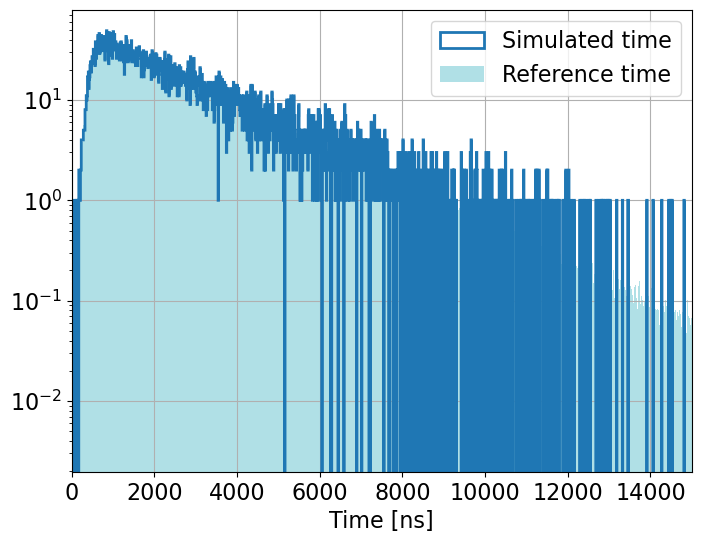

In [ ]:
fig, ax = plt.subplots( figsize = (8, 6) )  

ax.hist(t, bins = np.linspace(0, 15000, 1501), histtype = 'step', lw = 2, label = 'Simulated time')
ax.bar(t_bins[:-1], nuTime*nEvents/nuTime.sum(), width = np.diff(t_bins), align = "edge", 
       color = 'powderblue', label = 'Reference time')
ax.set_xlabel( 'Time [ns]', fontsize = 16 )
ax.tick_params(axis = 'x', labelsize = 16)
ax.tick_params(axis = 'y', labelsize = 16)
ax.set_xlim( [0, 15000])
ax.semilogy()
ax.grid(':')
ax.legend( fontsize = 16)
fig.savefig('TimeSimFull.pdf')

## Dirt

### Generation

In [10]:
infile = '/Users/yuntse/data/coherent/SNeNDSens/NueArCCdirt/marley/nueArCC_sns_yDir_01.hepevt'
outfile = '/Users/yuntse/data/coherent/SNeNDSens/NueArCCdirt/marley_xyzt/nueArCC_sns_yDir_01.hepevt'

rOutlim = 46
zOutlim = 60
nEvents = 10000
firstEvtNo = 10000

In [11]:
x, y, z = xyzDirt( rOutlim, -zOutlim, zOutlim, xlim, ylim, zlim, nEvents)
t = np.full(nEvents, 0)
x

array([15.49217   , -9.97433519,  1.92872623, ...,  7.31668266,
       43.29825309, 27.7597993 ])

In [12]:
events = readHepevt(infile, firstEvtNo)

updatedEvents = assignXYZT(events, x, y, z, t, firstEvtNo)
writeHepevt(updatedEvents, outfile)

In [19]:
len(t), len(x), len(y), len(z), len(events)

(5000, 5000, 5000, 5000, 10000)

In [15]:
np.all( (np.sqrt(x**2+y**2) <= rOutlim) & (np.abs(z) <= zOutlim) & ~(((np.abs(x) < xlim) & (np.abs(y) < ylim) & (np.abs(z) < zlim))) )

True